# Project: Evaluation of neural network architectures on MNIST datasets

## Group Members : Yidong HUANG, Simon ROBER, Marck-Edward KEMEH

### ABOUT
The MNIST dataset is a large database of handwritten digits used in many forms of image processing.
This dataset contains 60,000 training images and 10,000 test images. Our aim is to design some neural 
networks that can recognise these hand-written digits. our peojects will be based on two different networks
for this task.                   

In [11]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import scikitplot as skplt
import matplotlib.pyplot as plt

We begin by splitting the MNIST dataset into two. Aset for training and another for testing.
we then normalize the test set and training set by dividing with 255 so that the values can be between 0 and 1.
Becuase we will be working with convolutional neural network, we need to chnge the original shape of the MNIST 
dataset which is (60000, 28, 28) to that of the convolutional neural network (60000, 28, 28, 1).
this section is just to prepare our dataset for the network.

In [3]:
# dividing dataset into train and test set, also reshaping dataset to fit input of network
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print ('shape after adding dimension is :' ,x_train.shape)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)


### First Model
Our first model is a simple network definition which will be used to train the neural network.
our input shape has to match that of the train set as did above and we are using relu as activation
The convolutional layers play an important role in the learning ability of the network. Having more 
layers might improve the learning of the datasets hence have a high accuracy on the test sets.

Having a single convolutional layers with 32 filters gives us a test accuracy of 0.975.

        inputs = layers.Input(shape = (28,28,1))
        conv = layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu')(inputs)
        pool = layers.MaxPool2D((2,2), (2, 2))(conv)
        flat = layers.Flatten()(conv3)
        outputs = layers.Dense(10, activation = 'softmax')(flat)
        model = models.Model(inputs, outputs)
        model.summary()
        model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                        metrics = ["accuracy"])
                
                
Adding another convolutional layer with 64 number of filters increased the test accuracy to 0.984.
Adding a third layer with 124 filters and training 4 epochs increased the accuracy to 0.990
This tells us that more epochs also increases the learning accuracy
Model with 3 layers is shown below

In [4]:
#first simple model
inputs = layers.Input(shape = (28,28,1))
conv1 = layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu')(inputs)
pool1 = layers.MaxPool2D((2,2), (2, 2))(conv1)
conv2 = layers.Conv2D(64, (3,3), padding ='valid', activation = 'relu')(pool1)
pool2 = layers.MaxPool2D((2,2), (2, 2))(conv2)
conv3 = layers.Conv2D(128, (3,3), padding ='valid', activation = 'relu')(pool2)

flat = layers.Flatten()(conv3)
outputs = layers.Dense(10, activation = 'softmax')(flat)

model = models.Model(inputs, outputs)
model.summary()
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

We now test using our test set against the model we trained to determine if the model actually learnt to recognise the digits. for each epoch, we can see the loss rate is decreasing which tells us the model is actually improving on the learning.

In [10]:
#training
model.fit(x_train, y_train, epochs = 4)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 58s 964us/sample - loss: 0.0158 - accuracy: 0.9951
Epoch 2/4
60000/60000 [==============================] - 59s 985us/sample - loss: 0.0127 - accuracy: 0.9958
Epoch 3/4
60000/60000 [==============================] - 57s 957us/sample - loss: 0.0107 - accuracy: 0.9963
Epoch 4/4
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0094 - accuracy: 0.9971


We need some metrics  to determine the accuracy of recognition on the test set. we use accuracy to determine that.


In [6]:
# Accuracy:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

10000/10000 [==============================] - 2s 219us/sample - loss: 0.0315 - accuracy: 0.9896
test loss is : 0.03148479960879776 - test accuracy is : 0.9896000027656555


#### ROC
We implement the ROC curve to view the performance of our model on the test set

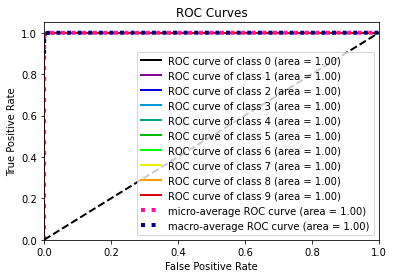

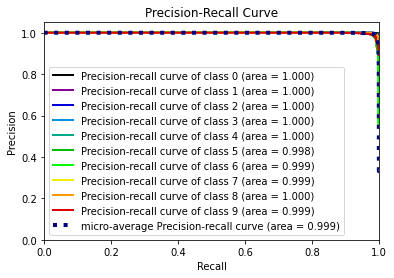

In [8]:
# ROC:
y_true = y_test # Given ground truth
y_probas = model.predict(x_test)
skplt.metrics.plot_roc(y_true, y_probas)     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
plt.show()

# Precision-Recall:
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.show()

### Second Model
Below is our second model which follows LeNet architecture and has an input shape of (32, 32, 1).

In [14]:
#second model
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))
model.summary()
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                1

In [61]:
# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model.fit(x_train, y_train, epochs = 4)
print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

Epoch 1/4
60000/60000 [==============================] - 18s 301us/sample - loss: 0.2294 - acc: 0.9316
Epoch 2/4
60000/60000 [==============================] - 20s 331us/sample - loss: 0.0793 - acc: 0.9759
Epoch 3/4
60000/60000 [==============================] - 18s 298us/sample - loss: 0.0582 - acc: 0.9817
Epoch 4/4
60000/60000 [==============================] - 18s 295us/sample - loss: 0.0456 - acc: 0.9860
test loss is : 2.30013422164917 - test accuracy is : 0.1565999984741211


10000/10000 [==============================] - 2s 162us/sample - loss: 0.0422 - acc: 0.9841
test loss is : 0.042205702858720905 - test accuracy is : 0.9840999841690063


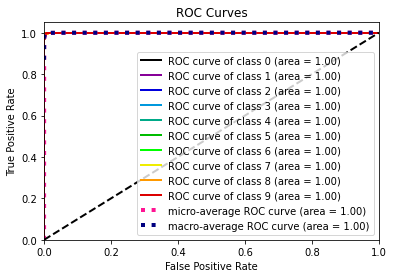

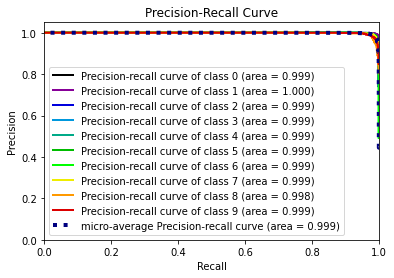

In [62]:
# Accuracy:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

# ROC:
y_true = y_test # Given ground truth
y_probas = model.predict(x_test)
skplt.metrics.plot_roc(y_true, y_probas)     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
plt.show()

# Precision-Recall:
skplt.metrics.plot_precision_recall(y_test, y_probas)
plt.show()